In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from collections import OrderedDict
from theano import shared, tensor as tt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 11.1

In [2]:
trolley_df = pd.read_csv('Data/Trolley.csv', sep=';')
trolley_df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


#### Code 11.2

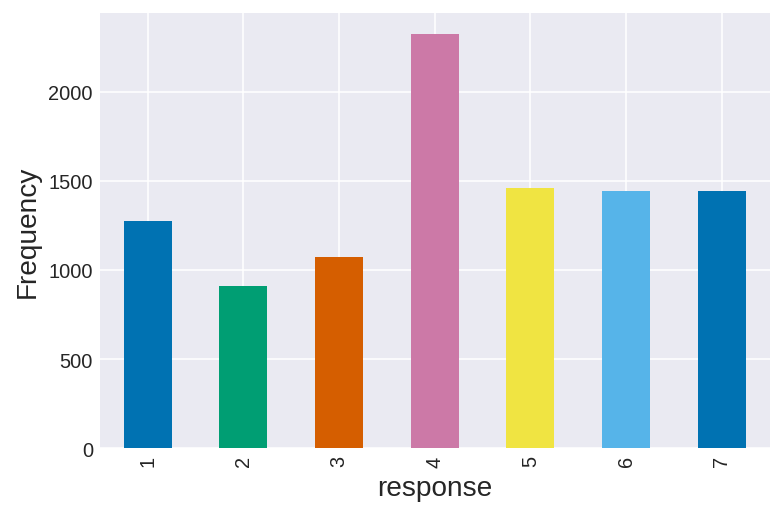

In [3]:
ax = (trolley_df.response
                .value_counts()
                .sort_index()
                .plot(kind='bar'))

ax.set_xlabel("response", fontsize=14);
ax.set_ylabel("Frequency", fontsize=14);

#### Code 11.3

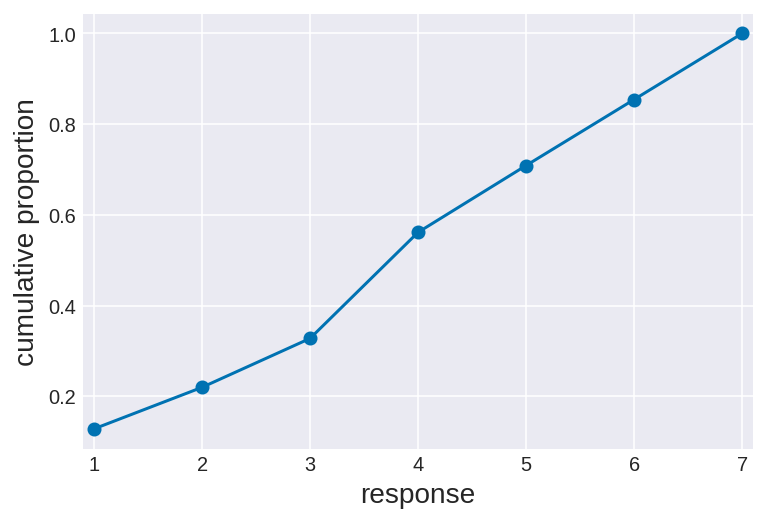

In [4]:
ax = (trolley_df.response
                .value_counts()
                .sort_index()
                .cumsum()
                .div(trolley_df.shape[0])
                .plot(marker='o'))

ax.set_xlim(0.9, 7.1);
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("cumulative proportion", fontsize=14);

#### Code 11.4

In [5]:
resp_lco = (trolley_df.response
                      .value_counts()
                      .sort_index()
                      .cumsum()
                      .iloc[:-1]
                      .div(trolley_df.shape[0])
                      .apply(lambda p: np.log(p / (1. - p))))

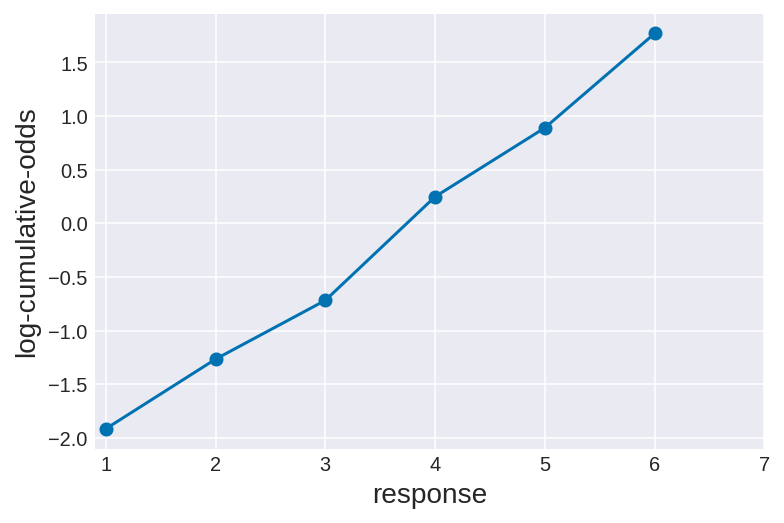

In [6]:
ax = resp_lco.plot(marker='o')

ax.set_xlim(0.9, 7);
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("log-cumulative-odds", fontsize=14);

#### Code 11.5

In [7]:
with pm.Model() as m11_1:
    a = pm.Normal(
        'a', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.arange(6) - 2.5)
    
    resp_obs = pm.OrderedLogistic(
        'resp_obs', 0., a,
        observed=trolley_df.response - 1
    )

In [8]:
with m11_1:
    map_11_1 = pm.find_MAP()

logp = -18,941, ||grad|| = 0.45229: 100%|██████████| 14/14 [00:00<00:00, 342.18it/s]  


#### Code 11.6

In [9]:
map_11_1['a']

array([-1.9160707 , -1.26658298, -0.71862013,  0.24778795,  0.88986631,
        1.76937289])

#### Code 11.7

In [10]:
sp.special.expit(map_11_1['a'])

array([0.12830038, 0.21984275, 0.32769691, 0.56163196, 0.70886258,
       0.85437967])

#### Code 11.8

In [11]:
with m11_1:
    trace_11_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:26<00:00, 226.73draws/s]


In [12]:
pm.summary(trace_11_1, varnames=['a'], alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,-1.92,0.03,0.0,-1.97,-1.87,3342.20,1.0
a__1,-1.27,0.02,0.0,-1.30,-1.23,4197.97,1.0
a__2,-0.72,0.02,0.0,-0.75,-0.69,4393.93,1.0
a__3,0.25,0.02,0.0,0.21,0.28,4068.49,1.0
a__4,0.89,0.02,0.0,0.86,0.93,4529.43,1.0
a__5,1.77,0.03,0.0,1.73,1.81,4522.24,1.0


#### Code 11.9

In [13]:
def ordered_logistic_proba(a):
    pa = sp.special.expit(a)
    p_cum = np.concatenate(([0.], pa, [1.]))
    
    return p_cum[1:] - p_cum[:-1]

In [14]:
ordered_logistic_proba(trace_11_1['a'].mean(axis=0))

array([0.1281844 , 0.0915567 , 0.10787774, 0.23393855, 0.14735085,
       0.14562705, 0.14546471])

#### Code 11.10

In [15]:
(ordered_logistic_proba(trace_11_1['a'].mean(axis=0)) \
     * (1 + np.arange(7))).sum()

4.199454755310227

#### Code 11.11

In [16]:
ordered_logistic_proba(trace_11_1['a'].mean(axis=0) - 0.5)

array([0.08187739, 0.06401652, 0.08222306, 0.20908761, 0.15909919,
       0.18454582, 0.21915041])

#### Code 11.12

In [17]:
(ordered_logistic_proba(trace_11_1['a'].mean(axis=0) - 0.5) \
     * (1 + np.arange(7))).sum()

4.7297538062325994

#### Code 11.13

In [18]:
action = shared(trolley_df.action.values)
intention = shared(trolley_df.intention.values)
contact = shared(trolley_df.contact.values)

with pm.Model() as m11_2:
    a = pm.Normal(
        'a', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=trace_11_1['a'].mean(axis=0)
    )
    
    bA = pm.Normal('bA', 0., 10.)
    bI = pm.Normal('bI', 0., 10.)
    bC = pm.Normal('bC', 0., 10.)
    phi = bA * action + bI * intention + bC * contact

    resp_obs = pm.OrderedLogistic(
        'resp_obs', phi, a,
        observed=trolley_df.response - 1
    )

In [19]:
with m11_2:
    map_11_2 = pm.find_MAP()

logp = -18,565, ||grad|| = 3.7428: 100%|██████████| 16/16 [00:00<00:00, 150.71it/s]  


#### Code 11.14

In [20]:
with pm.Model() as m11_3:
    a = pm.Normal(
        'a', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=trace_11_1['a'].mean(axis=0)
    )
    
    bA = pm.Normal('bA', 0., 10.)
    bI = pm.Normal('bI', 0., 10.)
    bC = pm.Normal('bC', 0., 10.)
    bAI = pm.Normal('bAI', 0., 10.)
    bCI = pm.Normal('bCI', 0., 10.)
    phi  = bA * action + bI * intention + bC * contact \
            + bAI * action * intention \
            + bCI * contact * intention

    resp_obs = pm.OrderedLogistic(
        'resp_obs', phi, a,
        observed=trolley_df.response - 1
    )

In [21]:
with m11_3:
    map_11_3 = pm.find_MAP()

logp = -18,489, ||grad|| = 0.73888: 100%|██████████| 26/26 [00:00<00:00, 148.59it/s]  


#### Code 11.15

In [22]:
def get_coefs(map_est):
    coefs = OrderedDict()
    
    for i, ai in enumerate(map_est['a']):
        coefs['a_{}'.format(i)] = ai
        
    coefs['bA'] = map_est.get('bA', np.nan)
    coefs['bI'] = map_est.get('bI', np.nan)
    coefs['bC'] = map_est.get('bC', np.nan)
    coefs['bAI'] = map_est.get('bAI', np.nan)
    coefs['bCI'] = map_est.get('bCI', np.nan)
        
    return coefs

In [23]:
(pd.DataFrame.from_dict(
    OrderedDict([
        ('m11_1', get_coefs(map_11_1)),
        ('m11_2', get_coefs(map_11_2)),
        ('m11_3', get_coefs(map_11_3))
    ]))
   .astype(np.float64)
   .round(2))

,m11_1,m11_2,m11_3
a_0,-1.92,-2.84,-2.63
a_1,-1.27,-2.16,-1.94
a_2,-0.72,-1.57,-1.34
a_3,0.25,-0.55,-0.31
a_4,0.89,0.12,0.36
a_5,1.77,1.02,1.27
bA,NaN,-0.71,-0.47
bAI,NaN,NaN,-0.45
bC,NaN,-0.96,-0.33
bCI,NaN,NaN,-1.27


#### Code 11.16

In [24]:
with m11_2:
    trace_11_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bC, bI, bA, a]
Sampling 3 chains: 100%|██████████| 6000/6000 [02:17<00:00, 43.70draws/s]


In [25]:
with m11_3:
    trace_11_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bCI, bAI, bC, bI, bA, a]
Sampling 3 chains: 100%|██████████| 6000/6000 [02:58<00:00, 33.57draws/s]


In [26]:
comp_df = pm.compare({m11_1:trace_11_1,
                      m11_2:trace_11_2,
                      m11_3:trace_11_3})

comp_df.loc[:,'model'] = pd.Series(['m11.1', 'm11.2', 'm11.3'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m11.3,36928.8,10.83,0,0.96,81.23,0,0
m11.2,37090,9.06,161.19,0,76.29,25.73,0
m11.1,37854.2,5.88,925.45,0.04,57.67,62.68,0


#### Code 11.17-19

In [27]:
pp_df = pd.DataFrame(np.array([[0, 0, 0],
                               [0, 0, 1],
                               [1, 0, 0],
                               [1, 0, 1],
                               [0, 1, 0],
                               [0, 1, 1]]),
                     columns=['action', 'contact', 'intention'])

In [28]:
pp_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [29]:
action.set_value(pp_df.action.values)
contact.set_value(pp_df.contact.values)
intention.set_value(pp_df.intention.values)

with m11_3:
    pp_trace_11_3 = pm.sample_ppc(trace_11_3, samples=1500)

100%|██████████| 1500/1500 [00:06<00:00, 241.12it/s]


In [30]:
PP_COLS = ['pp_{}'.format(i) for i, _ in enumerate(pp_trace_11_3['resp_obs'])]

pp_df = pd.concat((pp_df,
                   pd.DataFrame(pp_trace_11_3['resp_obs'].T, columns=PP_COLS)),
                  axis=1)

In [31]:
pp_cum_df = (pd.melt(
                    pp_df,
                    id_vars=['action', 'contact', 'intention'],
                    value_vars=PP_COLS, value_name='resp'
                )
               .groupby(['action', 'contact', 'intention', 'resp'])
               .size()
               .div(1500)
               .rename('proba')
               .reset_index()
               .pivot_table(
                   index=['action', 'contact', 'intention'],
                   values='proba',
                   columns='resp'
                )
               .cumsum(axis=1)
               .iloc[:, :-1])

In [32]:
pp_cum_df

resp                             0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.062000  0.126000  0.216000  0.423333  0.594000   
               1          0.092000  0.172667  0.265333  0.515333  0.673333   
       1       0          0.097333  0.174667  0.276000  0.496667  0.656667   
               1          0.318667  0.494000  0.626000  0.820667  0.888667   
1      0       0          0.094667  0.180000  0.301333  0.532667  0.695333   
               1          0.196000  0.332667  0.460000  0.712667  0.830667   

resp                             5  
action contact intention            
0      0       0          0.781333  
               1          0.825333  
       1       0          0.832000  
               1          0.948000  
1      0       0          0.844000  
               1          0.912000

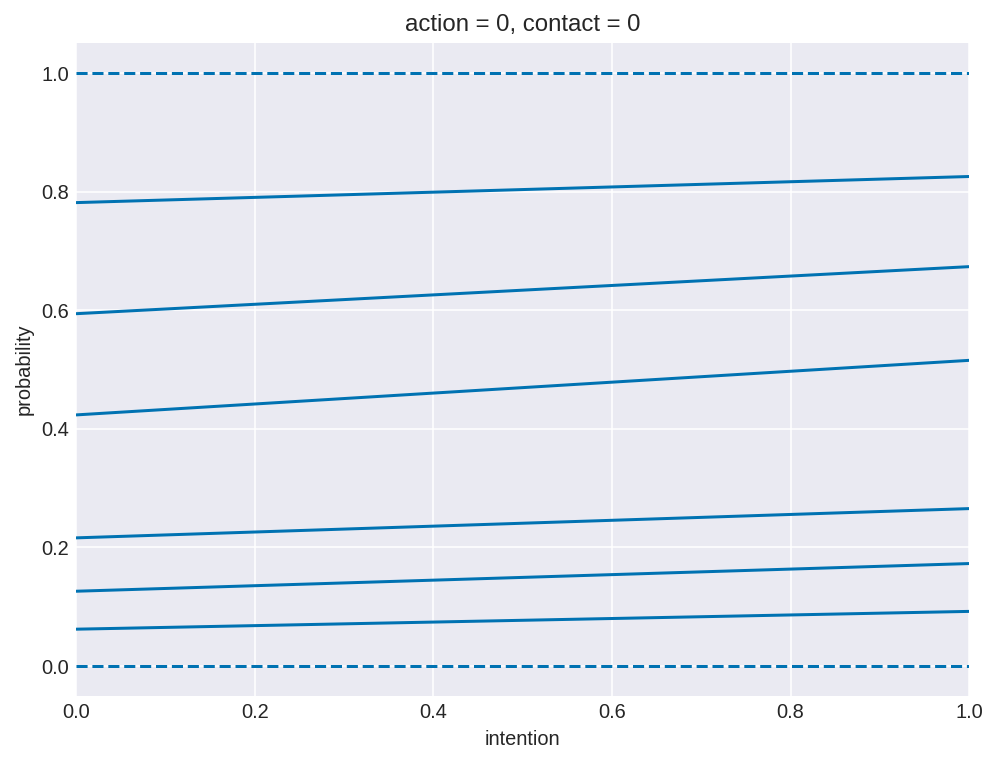

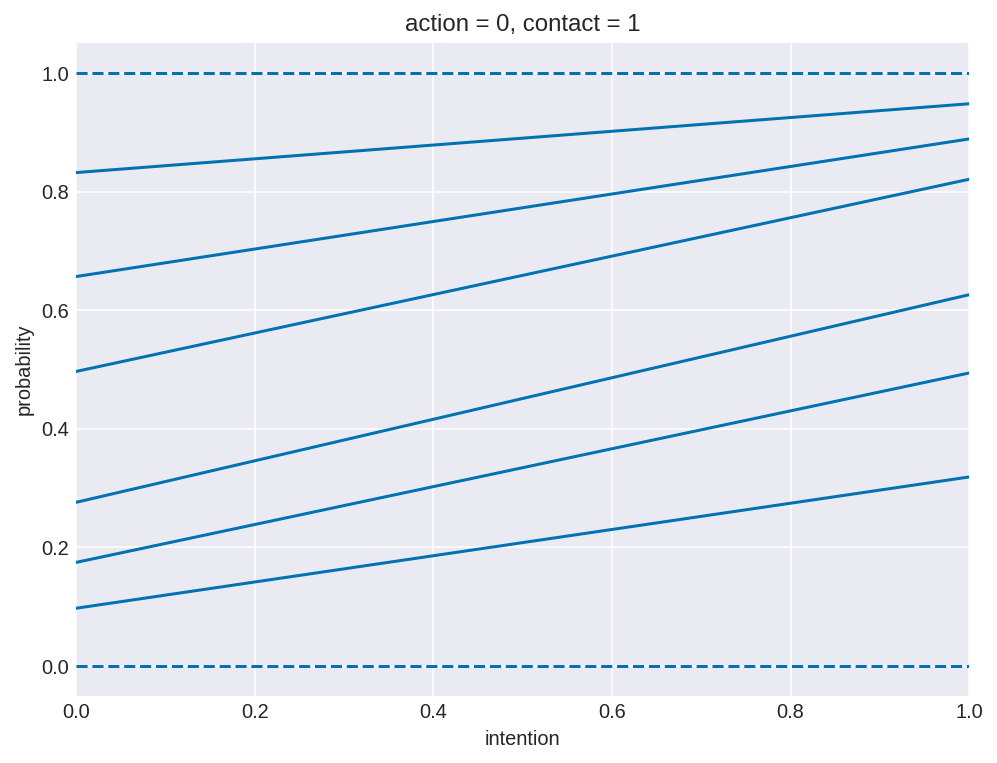

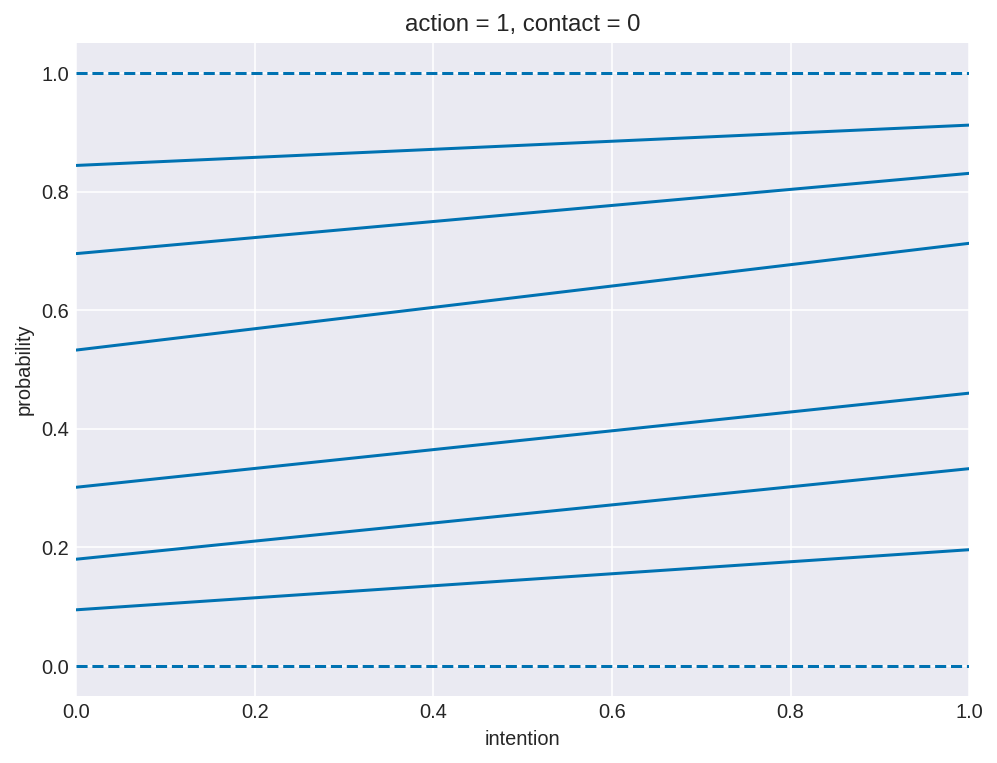

In [33]:
for (plot_action, plot_contact), plot_df in pp_cum_df.groupby(level=['action', 'contact']):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot([0, 1], plot_df, c='C0');
    ax.plot([0, 1], [0, 0], '--', c='C0');
    ax.plot([0, 1], [1, 1], '--', c='C0');
    
    ax.set_xlim(0, 1);
    ax.set_xlabel("intention");
    
    ax.set_ylim(-0.05, 1.05);
    ax.set_ylabel("probability");
    
    ax.set_title(
        "action = {action}, contact = {contact}".format(
            action=plot_action, contact=plot_contact
        )
    );

#### Code 11.20

In [34]:
# define parameters
PROB_DRINK = 0.2 # 20% of days
RATE_WORK = 1. # average 1 manuscript per day

# sample one year of production
N = 365

In [35]:
drink = np.random.binomial(1, PROB_DRINK, size=N)
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

#### Code 11.21

In [36]:
drink_zeros = drink.sum()
work_zeros = (y == 0).sum() - drink_zeros

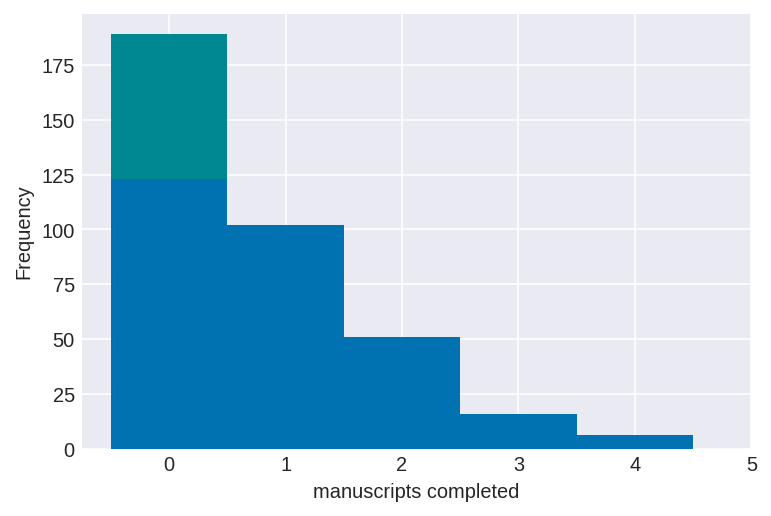

In [37]:
bins = np.arange(y.max() + 1) - 0.5

plt.hist(y, bins=bins);
plt.bar(0., drink_zeros, width=1., bottom=work_zeros, color='C1', alpha=.5);

plt.xticks(bins + 0.5);
plt.xlabel("manuscripts completed");

plt.ylabel("Frequency");

#### Code 11.22

In [38]:
with pm.Model() as m11_4:
    ap = pm.Normal('ap', 0., 1.)
    p = pm.math.sigmoid(ap)
    
    al = pm.Normal('al', 0., 10.)
    lambda_ = tt.exp(al)
    
    y_obs = pm.ZeroInflatedPoisson('y_obs', 1. - p, lambda_, observed=y)

In [39]:
with m11_4:
    map_11_4 = pm.find_MAP()

logp = -461.81, ||grad|| = 69.997: 100%|██████████| 11/11 [00:00<00:00, 480.73it/s]


In [40]:
map_11_4

{'ap': array(-1.02904826), 'al': array(0.04017238)}

#### Code 11.23

In [41]:
sp.special.expit(map_11_4['ap']) # probability drink

0.2632686609542555

In [42]:
np.exp(map_11_4['al']) # rate finish manuscripts, when not drinking

1.0409902057415978

#### Code 11.24

In [43]:
def dzip(x, p, lambda_, log=True):
    like = p**(x == 0) + (1 - p) * sp.stats.poisson.pmf(x, lambda_)
    
    return np.log(like) if log else like

#### Code 11.25

In [44]:
PBAR = 0.5
THETA = 5.

In [45]:
a = PBAR * THETA
b = (1 - PBAR) * THETA

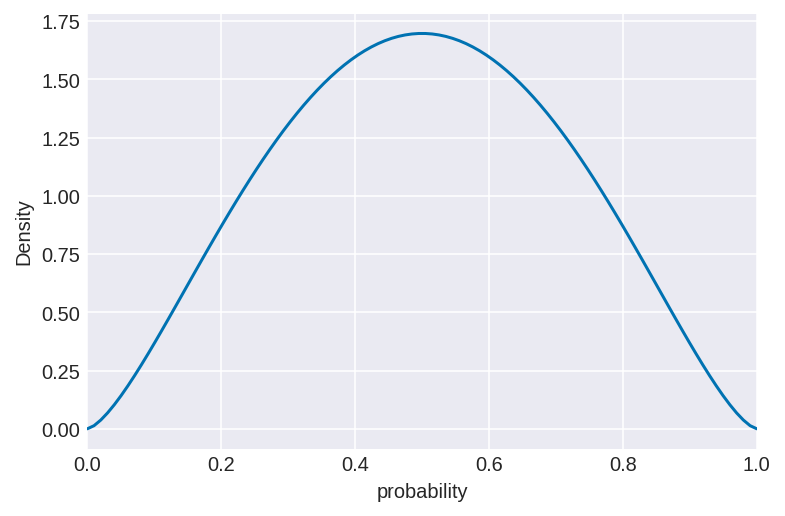

In [46]:
p = np.linspace(0, 1, 100)

plt.plot(p, sp.stats.beta.pdf(p, a, b));

plt.xlim(0, 1);
plt.xlabel("probability");

plt.ylabel("Density");

#### Code 11.26

In [47]:
admit_df = pd.read_csv('Data/UCBadmit.csv', sep=';')
admit_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [48]:
with pm.Model() as m11_5:
    a = pm.Normal('a', 0., 2.)
    pbar = pm.Deterministic('pbar', pm.math.sigmoid(a))

    theta = pm.Exponential('theta', 1.)
    
    admit_obs = pm.BetaBinomial(
        'admit_obs',
        pbar * theta, (1. - pbar) * theta,
        admit_df.applications.values,
        observed=admit_df.admit.values
    )

In [49]:
with m11_5:
    trace_11_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, a]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1880.46draws/s]


#### Code 11.27

In [50]:
pm.summary(trace_11_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.36,0.30,0.01,-0.82,0.13,2458.38,1.0
pbar,0.41,0.07,0.00,0.30,0.53,2443.76,1.0
theta,2.76,0.93,0.02,1.43,4.23,2638.01,1.0


#### Code 11.28

In [51]:
np.percentile(trace_11_5['pbar'], [2.5, 50., 97.5])

array([0.28001614, 0.40991493, 0.55641677])

#### Code 11.29

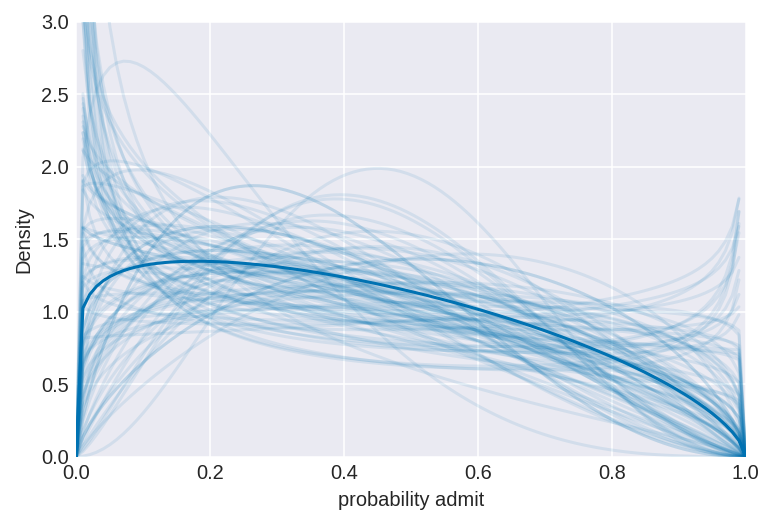

In [52]:
pbar_hat = trace_11_5['pbar'].mean()
theta_hat = trace_11_5['theta'].mean()

p_plot = np.linspace(0, 1, 100)

plt.plot(
    p_plot,
    sp.stats.beta.pdf(p_plot, pbar_hat * theta_hat, (1. - pbar_hat) * theta_hat)
);
plt.plot(
    p_plot,
    sp.stats.beta.pdf(
        p_plot[:, np.newaxis],
        trace_11_5['pbar'][:100] * trace_11_5['theta'][:100],
        (1. - trace_11_5['pbar'][:100]) * trace_11_5['theta'][:100]
    ),
    c='C0', alpha=0.1
);

plt.xlim(0., 1.);
plt.xlabel("probability admit");

plt.ylim(0., 3.);
plt.ylabel("Density");

#### Code 11.30

In [53]:
with m11_5:
    pp_trace_11_5 = pm.sample_ppc(trace_11_5)

100%|██████████| 1000/1000 [00:04<00:00, 205.48it/s]


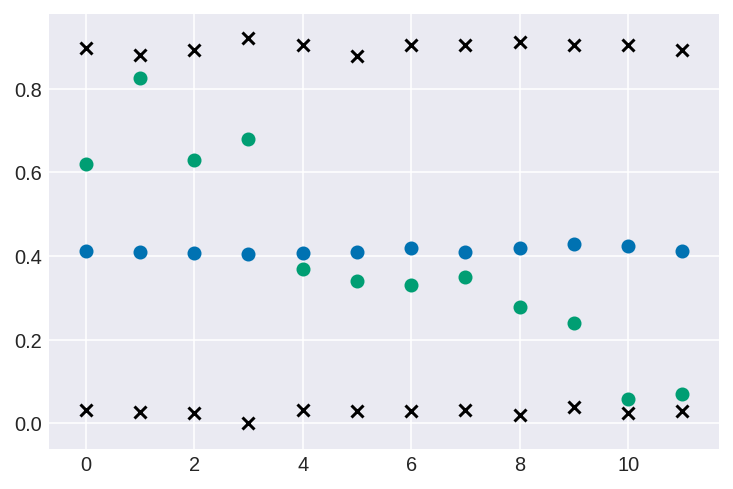

In [54]:
x_case = np.arange(admit_df.shape[0])

plt.scatter(
    x_case,
    pp_trace_11_5['admit_obs'].mean(axis=0) \
        / admit_df.applications.values
);
plt.scatter(x_case, admit_df.admit / admit_df.applications);

high = np.percentile(pp_trace_11_5['admit_obs'], 95, axis=0) \
        / admit_df.applications.values
plt.scatter(x_case, high, marker='x', c='k');

low = np.percentile(pp_trace_11_5['admit_obs'], 5, axis=0) \
        / admit_df.applications.values
plt.scatter(x_case, low, marker='x', c='k');

#### Code 11.31

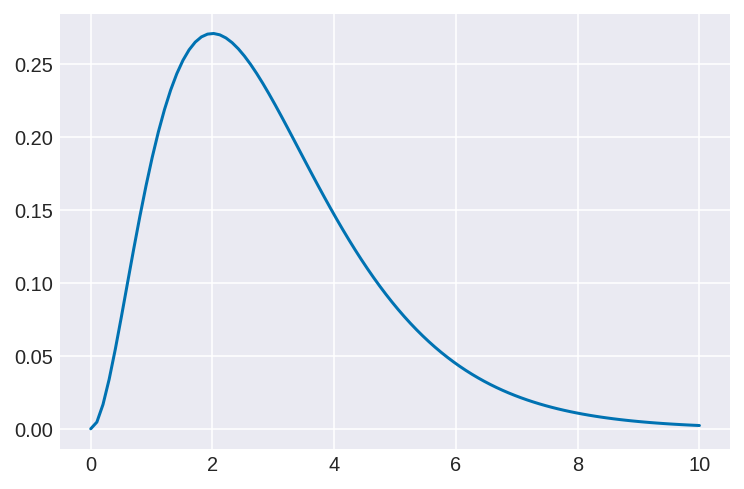

In [55]:
mu = 3.
theta = 1.

x = np.linspace(0, 10, 100)
plt.plot(x, sp.stats.gamma.pdf(x, mu / theta, scale=theta));

In [56]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian buster/sid and using:
Python 3.6.5
IPython 6.4.0
PyMC3 3.5.rc1
NumPy 1.14.5
Pandas 0.23.2
SciPy 1.1.0
Matplotlib 2.2.2

